# Project Data Lake

### Setup dan Konfigurasi

#### Import library

In [31]:
import pandas as pd
from sqlalchemy import create_engine, text
import os
import shutil
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import PyPDF2
from textblob import TextBlob
import random

#### Konfigurasi Koneksi Database

Konfigurasi koneksi ke database PostgreSQL

In [32]:
db_user = 'postgres'
db_password = 'ardiwinata230803'
db_host = 'localhost'
db_port = '5432'

Koneksi ke DB Staging Area (adventureworks_st)

In [33]:
db_name_st = 'adventureworks_st'
connection_string_st = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name_st}"
engine_st = create_engine(connection_string_st)
print(f"✅ Koneksi ke database Staging Area ('{db_name_st}') berhasil!")

✅ Koneksi ke database Staging Area ('adventureworks_st') berhasil!


Koneksi ke DB Data Warehouse (adventureworks_wh)

In [34]:
db_name_wh = 'adventureworks_wh'
connection_string_wh = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name_wh}"
engine_wh = create_engine(connection_string_wh)
print(f"✅ Koneksi ke database Data Warehouse ('{db_name_wh}') berhasil!")

✅ Koneksi ke database Data Warehouse ('adventureworks_wh') berhasil!


#### Konfigurasi Path Folder

In [35]:
ORGANIZED_PATH = 'data_organized'
RAW_DATA_PATH = 'data_raw'
OUTPUT_PATH = 'output'

print("✅ Semua path folder berhasil dikonfigurasi.")

✅ Semua path folder berhasil dikonfigurasi.


#### Definisi Nama Kolom untuk Data Raw

Ini penting untuk membaca file CSV yang tidak memiliki header

In [36]:
pelanggan_cols = ['id_pelanggan', 'nama_depan', 'nama_belakang', 'email', 'kota_asal']
produk_cols = ['id_produk', 'nama_produk', 'subkategori', 'kategori', 'harga_standar', 'warna', 'lini_produk']
penjualan_cols = ['id_order', 'id_order_detail', 'tanggal_order', 'id_pelanggan', 'id_produk', 'jumlah_barang', 'harga_satuan', 'total_harga']

#### Status Konfigurasi

In [37]:
print("✅ Setup dan Konfigurasi Selesai.")

✅ Setup dan Konfigurasi Selesai.


### Kumpulan Fungsi ETL

Sortir file dalam folder

In [38]:
def sortir_file_mentah():
    """Menyalin file dari landing zone ke folder terorganisir berdasarkan tipe."""
    print("\n--- Memulai Proses Sortir File Mentah ---")
    source_path = 'data_raw' # Kita anggap ini landing zone-nya
    
    # Membaca dari data_raw dan menyalin ke data_organized
    for filename in os.listdir(source_path):
        file_path = os.path.join(source_path, filename)
        _, ext = os.path.splitext(filename)
        ext = ext.lower()
        
        target_dir = None
        if ext == '.csv': target_dir = os.path.join(ORGANIZED_PATH, 'csv')
        elif ext == '.pdf': target_dir = os.path.join(ORGANIZED_PATH, 'pdf')
        elif ext == '.txt': target_dir = os.path.join(ORGANIZED_PATH, 'txt')
        
        if target_dir:
            os.makedirs(target_dir, exist_ok=True)
            shutil.copy(file_path, os.path.join(target_dir, filename))
            print(f"  -> File '{filename}' disalin ke '{target_dir}'")
    print("✅ Proses Sortir File Selesai.")

Kode fungsi reset

In [39]:
def reset_all_tables():
    """Mengosongkan semua tabel DWH & Staging sebelum diisi ulang."""
    print("\n--- MERESET SEMUA TABEL DI adventureworks_st ---")
    with engine_st.connect() as connection:
        try:
            # Menggunakan CASCADE untuk menangani dependensi foreign key
            connection.execute(text('TRUNCATE TABLE "Fakta_Penjualan", "Dim_Waktu", "Dim_Lokasi", "Dim_Produk", "Dim_Pelanggan", stg_dokumen_pdf, stg_analisis_sentimen RESTART IDENTITY CASCADE;'))
            connection.commit()
            print("✅ Semua tabel di adventureworks_st berhasil dikosongkan.")
        except Exception as e:
            print(f"⚠️ Gagal mereset tabel: {e}")

Kode fungsu etl pelanggan

In [40]:
def etl_dim_pelanggan_scd2():
    print("\n--- Memulai ETL SCD Tipe 2 untuk Dim_Pelanggan ---")
    path_sumber = os.path.join(ORGANIZED_PATH, 'csv', 'raw_pelanggan.csv')
    source_df = pd.read_csv(path_sumber, sep=',', header=None, skiprows=1, names=pelanggan_cols)
    source_df['nama_lengkap'] = source_df['nama_depan'] + ' ' + source_df['nama_belakang']
    try:
        dwh_df = pd.read_sql_query('SELECT * FROM "Dim_Pelanggan" WHERE status_sekarang = TRUE', engine_st)
    except:
        dwh_df = pd.DataFrame(columns=['pelanggan_key', 'id_pelanggan', 'nama_lengkap', 'email', 'kota_asal', 'tanggal_mulai', 'tanggal_akhir', 'status_sekarang'])
        
    merged_df = pd.merge(source_df, dwh_df, on='id_pelanggan', how='left', suffixes=('_new', '_old'), indicator=True)
    new_records = merged_df[merged_df['_merge'] == 'left_only'].copy(); new_to_insert = new_records[['id_pelanggan', 'nama_lengkap_new', 'email_new', 'kota_asal_new']].copy(); new_to_insert.rename(columns={'nama_lengkap_new': 'nama_lengkap', 'email_new': 'email', 'kota_asal_new': 'kota_asal'}, inplace=True)
    new_to_insert['tanggal_mulai'] = '1900-01-01'; new_to_insert['tanggal_akhir'] = '9999-12-31'; new_to_insert['status_sekarang'] = True
    changed_df = merged_df[merged_df['_merge'] == 'both'].copy(); changed_df = changed_df[changed_df['kota_asal_new'] != changed_df['kota_asal_old']]
    keys_to_expire = changed_df['pelanggan_key'].astype(int).tolist() if not changed_df.empty else []
    updates_as_new = changed_df[['id_pelanggan', 'nama_lengkap_new', 'email_new', 'kota_asal_new']].copy(); updates_as_new.rename(columns={'nama_lengkap_new': 'nama_lengkap', 'email_new': 'email', 'kota_asal_new': 'kota_asal'}, inplace=True)
    updates_as_new['tanggal_mulai'] = date.today(); updates_as_new['tanggal_akhir'] = '9999-12-31'; updates_as_new['status_sekarang'] = True
    records_to_insert = pd.concat([new_to_insert, updates_as_new], ignore_index=True)

    with engine_st.connect() as connection:
        if keys_to_expire:
            connection.execute(text(f"""UPDATE "Dim_Pelanggan" SET status_sekarang = FALSE, tanggal_akhir = '{date.today()}' WHERE pelanggan_key IN ({','.join(map(str, keys_to_expire))})""")); connection.commit()
    if not records_to_insert.empty:
        records_to_insert.to_sql('Dim_Pelanggan', engine_st, if_exists='append', index=False, chunksize=1000)
    print(f"✅ SUKSES! Proses SCD Tipe 2 Dim_Pelanggan selesai.")

Kode fungsi etl produk

In [41]:
def etl_dim_produk():
    print("\n--- Memulai ETL Dim_Produk ---")
    path_sumber = os.path.join(ORGANIZED_PATH, 'csv', 'raw_produk.csv')
    df = pd.read_csv(path_sumber, sep=',', header=None, skiprows=1, names=produk_cols)
    df['warna'].fillna('Tidak Berwarna', inplace=True)
    df.to_sql('Dim_Produk', engine_st, if_exists='append', index=False, chunksize=1000)
    print(f"✅ SUKSES! {len(df)} baris dimuat ke Dim_Produk.")

Kode fungsi etl lokasi

In [42]:
def etl_dim_lokasi():
    print("\n--- Memulai ETL Dim_Lokasi ---")
    # E: Extract (Ingest data mentah pelanggan dari CSV untuk mendapatkan kota_asal)
    df = pd.read_csv(os.path.join(ORGANIZED_PATH, 'csv', 'raw_pelanggan.csv'), sep=',', header=None, skiprows=1, names=pelanggan_cols)
    
    # T: Transform (Mengambil nilai unik dari kolom 'kota_asal' dan buang nilai NaN)
    df_final = pd.DataFrame(df['kota_asal'].unique(), columns=['nama_kota']).dropna()
    
    # L: Load (Muat data ke Dim_Lokasi di adventureworks_st)
    df_final.to_sql('Dim_Lokasi', engine_st, if_exists='append', index=False, chunksize=1000)
    print(f"✅ SUKSES! {len(df_final)} baris dimuat ke Dim_Lokasi.")

Kode fungsi etl waktu

In [43]:
def etl_dim_waktu():
    print("\n--- Memulai ETL Dim_Waktu ---")
    # E: Extract (Ingest data mentah penjualan dari CSV untuk mendapatkan rentang tanggal)
    df = pd.read_csv(os.path.join(ORGANIZED_PATH, 'csv', 'raw_penjualan.csv'), sep=',', header=None, skiprows=1, names=penjualan_cols)
    df['tanggal_order'] = pd.to_datetime(df['tanggal_order'])
    
    # T: Transform (Membuat rentang tanggal unik dan atribut waktu)
    date_range = pd.date_range(df['tanggal_order'].min(), df['tanggal_order'].max(), freq='D')
    df_final = pd.DataFrame(date_range, columns=['tanggal'])
    
    df_final['id_waktu'] = df_final['tanggal'].dt.strftime('%Y%m%d').astype(int)
    df_final['tahun'] = df_final['tanggal'].dt.year
    df_final['kuartal'] = df_final['tanggal'].dt.quarter
    df_final['bulan'] = df_final['tanggal'].dt.month
    df_final['nama_bulan'] = df_final['tanggal'].dt.strftime('%B')
    df_final['hari'] = df_final['tanggal'].dt.day
    df_final['nama_hari'] = df_final['tanggal'].dt.strftime('%A')
    
    # L: Load (Muat data ke Dim_Waktu di adventureworks_st)
    df_final.to_sql('Dim_Waktu', engine_st, if_exists='append', index=False, chunksize=1000)
    print(f"✅ SUKSES! {len(df_final)} baris dimuat ke Dim_Waktu.")

Kode fungsi etl pdf

In [44]:
def etl_pdf_to_staging():
    print("\n--- Memulai ETL untuk file PDF ---")
    
    # Tentukan path folder PDF
    pdf_folder = os.path.join(ORGANIZED_PATH, 'pdf')
    
    # List kosong untuk menampung hasil ekstraksi
    hasil_ekstraksi = []
    
    try:
        # Loop melalui semua file di dalam folder pdf
        for filename in os.listdir(pdf_folder):
            if filename.lower().endswith('.pdf'):
                print(f"  -> Memproses file: {filename}...")
                file_path = os.path.join(pdf_folder, filename)
                
                text = ""
                # Buka dan baca file PDF
                with open(file_path, 'rb') as file:
                    reader = PyPDF2.PdfReader(file)
                    for page in reader.pages:
                        text += page.extract_text() + "\n" # Tambah baris baru antar halaman
                
                # Tambahkan hasil ke list
                hasil_ekstraksi.append({
                    'nama_file': filename,
                    'isi_teks': text
                })
        
        if not hasil_ekstraksi:
            print("⚠️ Tidak ada file PDF yang ditemukan untuk diproses.")
            return

        # Transformasi: Ubah list menjadi DataFrame dan tambahkan timestamp
        df_pdf = pd.DataFrame(hasil_ekstraksi)
        df_pdf['tgl_ekstrak'] = datetime.now()
        
        # Load: Masukkan data ke tabel stg_dokumen_pdf
        target_table_name = 'stg_dokumen_pdf'
        print(f"   -> Memuat {len(df_pdf)} dokumen ke tabel '{target_table_name}'...")
        
        # Kita pakai 'replace' untuk staging, agar setiap run hasilnya fresh
        df_pdf.to_sql(target_table_name, engine_st, if_exists='replace', index=False)

        print(f"✅ SUKSES! ETL untuk PDF selesai.")

    except Exception as e:
        print(f"❌ GAGAL! Terjadi error saat proses ETL PDF: {e}")

Kode fungsi etl txt

In [45]:
def etl_txt_to_staging():
    print("\n--- Memulai ETL TXT dengan ID Pelanggan ---")
    
    txt_folder = os.path.join(ORGANIZED_PATH, 'txt')
    hasil_analisis = []
    
    try:
        # Langkah Baru 1: Ambil daftar ID pelanggan asli dari DWH
        print("  -> Mengambil daftar ID pelanggan dari Dim_Pelanggan...")
        list_id_pelanggan = pd.read_sql_query('SELECT id_pelanggan FROM "Dim_Pelanggan"', engine_st)['id_pelanggan'].tolist()
        
        if not list_id_pelanggan:
            print("⚠️ GAGAL! Tidak ada data pelanggan di Dim_Pelanggan untuk dijadikan referensi.")
            return

        print(f"  -> Ditemukan {len(list_id_pelanggan)} ID pelanggan.")

        # Loop melalui file TXT
        for filename in os.listdir(txt_folder):
            if filename.lower().endswith('.txt'):
                print(f"  -> Menganalisis file: {filename}...")
                file_path = os.path.join(txt_folder, filename)
                
                with open(file_path, 'r', encoding='utf-8') as file:
                    text = file.read()
                
                blob = TextBlob(text)
                
                # Langkah Baru 2: Pilih ID pelanggan secara acak dan tempelkan
                random_customer_id = random.choice(list_id_pelanggan)
                
                hasil_analisis.append({
                    'id_pelanggan': random_customer_id, # <-- KOLOM BARU
                    'nama_file': filename,
                    'isi_tweet': text,
                    'polarity': blob.sentiment.polarity,
                    'subjectivity': blob.sentiment.subjectivity
                })
        
        # ... (Sisa prosesnya sama)
        df_txt = pd.DataFrame(hasil_analisis)
        df_txt['tgl_ekstrak'] = datetime.now()
        
        target_table_name = 'stg_analisis_sentimen'
        
        # Kita perlu pastikan tabelnya bisa menampung kolom baru
        # Cara paling aman adalah dengan 'replace' karena ini tabel staging
        print(f"   -> Memuat {len(df_txt)} hasil analisis ke tabel '{target_table_name}'...")
        df_txt.to_sql(target_table_name, engine_st, if_exists='replace', index=False)

        print(f"✅ SUKSES! ETL untuk TXT dengan ID pelanggan selesai.")

    except Exception as e:
        print(f"❌ GAGAL! Terjadi error saat proses ETL TXT: {e}")

Kode fungsi etl fakta

In [46]:
def etl_fakta_penjualan():
    print("\n--- Memulai ETL Fakta_Penjualan (Versi Final & Robust) ---")
    
    try:
        # --- EXTRACT ---
        print("   -> [E] Mengekstrak data penjualan mentah...")
        df_penjualan = pd.read_csv(os.path.join(ORGANIZED_PATH, 'csv', 'raw_penjualan.csv'), sep=',', header=None, skiprows=1, names=penjualan_cols)
        
        print("   -> [E] Mengekstrak dimensi AKTIF dari DWH...")
        # KUNCI UTAMA: Kita hanya ambil data pelanggan yang statusnya saat ini aktif
        df_dim_pelanggan_aktif = pd.read_sql_query('SELECT pelanggan_key, id_pelanggan, kota_asal FROM "Dim_Pelanggan" WHERE status_sekarang = TRUE', engine_st)
        df_dim_lokasi = pd.read_sql_table('Dim_Lokasi', engine_st)
        
        # --- TRANSFORM ---
        print("   -> [T] Melakukan transformasi dan penggabungan data...")
        
        # 1. Buat id_waktu dari tanggal_order
        df_penjualan['tanggal_order'] = pd.to_datetime(df_penjualan['tanggal_order'])
        df_penjualan['id_waktu'] = df_penjualan['tanggal_order'].dt.strftime('%Y%m%d').astype(int)

        # 2. Gabungkan penjualan dengan pelanggan AKTIF untuk mendapatkan pelanggan_key dan kota_asal
        # Kita pakai INNER JOIN untuk memastikan hanya penjualan dari pelanggan yang terdaftar di DWH yang masuk
        df_merged = pd.merge(df_penjualan, df_dim_pelanggan_aktif, on='id_pelanggan', how='inner')
        
        # 3. Gabungkan dengan Dim_Lokasi untuk mendapatkan id_lokasi
        df_final = pd.merge(df_merged, df_dim_lokasi, left_on='kota_asal', right_on='nama_kota', how='left')

        # 4. Pilih kolom final sesuai struktur tabel Fakta_Penjualan yang baru
        kolom_final = [
            'id_order_detail', 
            'id_order', 
            'pelanggan_key', # <-- Ini kunci surrogate kita
            'id_produk', 
            'id_waktu', 
            'id_lokasi', 
            'jumlah_barang', 
            'harga_satuan', 
            'total_harga'
        ]
        df_final = df_final[kolom_final].copy()
        
        # 5. Jaring pengaman duplikat terakhir
        df_final.drop_duplicates(subset=['id_order_detail'], keep='first', inplace=True)

        # --- LOAD ---
        print(f"   -> [L] Memuat {len(df_final)} baris data ke Fakta_Penjualan...")
        if len(df_final) > 0:
            df_final.to_sql('Fakta_Penjualan', engine_st, if_exists='append', index=False, chunksize=1000)
            print("\n✅ Proses ETL untuk Fakta_Penjualan selesai!")
        else:
            print("\n⚠️ Tidak ada data yang valid untuk dimuat ke Fakta_Penjualan.")
            
    except Exception as e:
        print(f"❌ GAGAL! Terjadi error saat ETL Fakta Penjualan: {e}")

#### Status Fungsi ETL

In [47]:
print("✅ Semua fungsi ETL berhasil didefinisikan.")

✅ Semua fungsi ETL berhasil didefinisikan.


### Eksekusi Pipeline Utama

In [48]:
try:
    print("\n\n===== MEMULAI PIPELINE ETL LENGKAP =====")
    
    # 0. Sortir file mentah
    sortir_file_mentah()
    
    # 1. Kosongkan semua tabel DWH
    reset_all_tables()
    
    # 2. Bangun Dimensi Utama dulu
    etl_dim_produk()
    etl_dim_waktu()
    # PENTING: Pelanggan dijalankan dulu karena jadi referensi untuk lokasi dan txt
    etl_dim_pelanggan_scd2() 
    etl_dim_lokasi()

    # 3. Proses data tidak terstruktur ke staging
    etl_pdf_to_staging()
    etl_txt_to_staging()

    # 4. Bangun Tabel Fakta (setelah semua dimensi siap)
    etl_fakta_penjualan()
    
    print("\n\n===== PIPELINE ETL SELESAI DENGAN SUKSES! =====")

except Exception as e:
    print(f"\n❌ GAGAL! Error saat eksekusi pipeline: {e}")



===== MEMULAI PIPELINE ETL LENGKAP =====

--- Memulai Proses Sortir File Mentah ---
  -> File 'Laporan Penjualan Q1 2025.pdf' disalin ke 'data_organized\pdf'
  -> File 'raw_pelanggan.csv' disalin ke 'data_organized\csv'
  -> File 'raw_penjualan.csv' disalin ke 'data_organized\csv'
  -> File 'raw_produk.csv' disalin ke 'data_organized\csv'
  -> File 'tweet-1.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-10.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-11.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-12.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-13.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-14.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-15.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-16.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-17.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-18.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-19.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-2.txt' disalin

C:\Users\Pongo\AppData\Local\Temp\ipykernel_24944\323935732.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['warna'].fillna('Tidak Berwarna', inplace=True)


✅ SUKSES! 1127 baris dimuat ke Dim_Waktu.

--- Memulai ETL SCD Tipe 2 untuk Dim_Pelanggan ---
✅ SUKSES! Proses SCD Tipe 2 Dim_Pelanggan selesai.

--- Memulai ETL Dim_Lokasi ---
✅ SUKSES! 269 baris dimuat ke Dim_Lokasi.

--- Memulai ETL untuk file PDF ---
  -> Memproses file: Laporan Penjualan Q1 2025.pdf...
   -> Memuat 1 dokumen ke tabel 'stg_dokumen_pdf'...
✅ SUKSES! ETL untuk PDF selesai.

--- Memulai ETL TXT dengan ID Pelanggan ---
  -> Mengambil daftar ID pelanggan dari Dim_Pelanggan...
  -> Ditemukan 19119 ID pelanggan.
  -> Menganalisis file: tweet-1.txt...
  -> Menganalisis file: tweet-10.txt...
  -> Menganalisis file: tweet-11.txt...
  -> Menganalisis file: tweet-12.txt...
  -> Menganalisis file: tweet-13.txt...
  -> Menganalisis file: tweet-14.txt...
  -> Menganalisis file: tweet-15.txt...
  -> Menganalisis file: tweet-16.txt...
  -> Menganalisis file: tweet-17.txt...
  -> Menganalisis file: tweet-18.txt...
  -> Menganalisis file: tweet-19.txt...
  -> Menganalisis file: tweet

### Analyze (Analisis Data dari Data Staging Area)

#### Analisis 1: Total Penjualan per Kategori Produk

Query ini akan menghitung total penjualan untuk setiap kategori produk dari `Fakta_Penjualan` dan `Dim_Produk`

In [49]:
print("\n\n--- Memulai Analisis 1: Total Penjualan per Kategori Produk ---")
print("Menjalankan query analisis penjualan per kategori dari adventureworks_st...")

query_kategori = """
SELECT dp.kategori, SUM(fp.total_harga) AS total_penjualan
FROM "Fakta_Penjualan" fp
JOIN "Dim_Produk" dp ON fp.id_produk = dp.id_produk
GROUP BY dp.kategori
ORDER BY total_penjualan DESC;
"""
df_kategori = pd.read_sql_query(query_kategori, engine_st)
print("✅ Query berhasil dieksekusi! Hasil analisis:\n")
display(df_kategori)



--- Memulai Analisis 1: Total Penjualan per Kategori Produk ---
Menjalankan query analisis penjualan per kategori dari adventureworks_st...
✅ Query berhasil dieksekusi! Hasil analisis:



,kategori,total_penjualan
0,Bikes,9.514581e+07
1,Components,1.180781e+07
2,Clothing,2.141507e+06
3,Accessories,1.278761e+06


#### Analisis 2: Tren Penjualan Bulanan

Query ini akan menghitung total penjualan per bulan untuk melihat tren penjualan dari waktu ke waktu

In [50]:
print("\n\n--- Memulai Analisis 2: Tren Penjualan Bulanan ---")
print("Menjalankan query analisis tren penjualan bulanan dari adventureworks_st...")

query_tren = """
SELECT w.tahun, w.bulan, TO_DATE(w.tahun || '-' || w.bulan, 'YYYY-MM') AS periode, SUM(fp.total_harga) AS total_penjualan
FROM "Fakta_Penjualan" fp
JOIN "Dim_Waktu" w ON fp.id_waktu = w.id_waktu
GROUP BY w.tahun, w.bulan
ORDER BY w.tahun, w.bulan;
"""
df_tren = pd.read_sql_query(query_tren, engine_st)
print("✅ Query tren penjualan berhasil dieksekusi! Hasil analisis:\n")
display(df_tren)



--- Memulai Analisis 2: Tren Penjualan Bulanan ---
Menjalankan query analisis tren penjualan bulanan dari adventureworks_st...
✅ Query tren penjualan berhasil dieksekusi! Hasil analisis:



,tahun,bulan,periode,total_penjualan
0,2011,5,2011-05-01,5.038059e+05
1,2011,6,2011-06-01,4.589108e+05
2,2011,7,2011-07-01,2.046265e+06
3,2011,8,2011-08-01,2.496365e+06
4,2011,9,2011-09-01,5.020738e+05
5,2011,10,2011-10-01,4.590875e+06
6,2011,11,2011-11-01,7.378398e+05
7,2011,12,2011-12-01,1.309977e+06
8,2012,1,2012-01-01,3.970636e+06
9,2012,2,2012-02-01,1.475538e+06


#### Analisis 3: Top 10 Pelanggan dengan Total Belanja Terbanyak

Query ini akan mengidentifikasi 10 pelanggan teratas berdasarkan total belanja mereka, dengan mempertimbangkan status aktif pelanggan (pentingnya SCD Tipe 2)

In [51]:
print("\n\n--- Memulai Analisis 3: Top 10 Pelanggan ---")
print("Menjalankan query analisis top 10 pelanggan dari adventureworks_st...")

query_top_cust = """
SELECT
    p.nama_lengkap,
    SUM(fp.total_harga) AS total_belanja
FROM "Fakta_Penjualan" fp
-- INI BAGIAN YANG DIPERBAIKI: Join menggunakan pelanggan_key
JOIN "Dim_Pelanggan" p ON fp.pelanggan_key = p.pelanggan_key
WHERE
    p.status_sekarang = TRUE -- Penting: Hanya ambil pelanggan yang statusnya TRUE (aktif)
GROUP BY
    p.nama_lengkap
ORDER BY
    total_belanja DESC
LIMIT 10;
"""

df_top_cust = pd.read_sql_query(query_top_cust, engine_st)
print("✅ Query top 10 pelanggan berhasil dieksekusi! Hasil analisis:\n")
display(df_top_cust)



--- Memulai Analisis 3: Top 10 Pelanggan ---
Menjalankan query analisis top 10 pelanggan dari adventureworks_st...
✅ Query top 10 pelanggan berhasil dieksekusi! Hasil analisis:



,nama_lengkap,total_belanja
0,Roger Harui,882472.7866
1,Reuben D'sa,860147.5110
2,Andrew Dixon,853850.6395
3,Robert Vessa,817127.8029
4,Ryan Calafato,803769.8509
5,Joseph Castellucio,787808.8350
6,Kirk DeGrasse,751632.8575
7,Lindsey Camacho,741363.2168
8,Robin McGuigan,735235.7035
9,Stacey Cereghino,731636.8633


#### Analisis 4: Korelasi Sentimen vs Penjualan

In [52]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime
import os
print("--- Memulai Analisis Final: Korelasi Sentimen vs Penjualan ---")

query_final = """
WITH
    -- Langkah 1: Hitung total belanja untuk setiap pelanggan aktif
    BelanjaPelanggan AS (
        SELECT
            p.id_pelanggan, -- Ambil id_pelanggan dari tabel dimensi
            p.nama_lengkap,
            SUM(fp.total_harga) AS total_belanja
        FROM "Fakta_Penjualan" fp
        -- INI BAGIAN YANG DIPERBAIKI: Join menggunakan pelanggan_key
        JOIN "Dim_Pelanggan" p ON fp.pelanggan_key = p.pelanggan_key
        WHERE p.status_sekarang = TRUE -- Filter hanya pelanggan aktif
        GROUP BY p.id_pelanggan, p.nama_lengkap
    ),
    -- Langkah 2: Ambil data sentimen pelanggan dari tabel staging
    SentimenPelanggan AS (
        SELECT
            id_pelanggan,
            polarity,
            isi_tweet
        FROM stg_analisis_sentimen
    )
-- Langkah 3: Gabungkan keduanya berdasarkan id_pelanggan
SELECT
    bp.nama_lengkap,
    sp.polarity,
    bp.total_belanja,
    sp.isi_tweet
FROM SentimenPelanggan sp
JOIN BelanjaPelanggan bp ON sp.id_pelanggan = bp.id_pelanggan
ORDER BY
    sp.polarity DESC, total_belanja DESC;
"""

try:
    df_final_report = pd.read_sql_query(query_final, engine_st)
    print("✅ Query analisis gabungan berhasil dieksekusi! Ini hasilnya:")
    display(df_final_report)
except Exception as e:
    print(f"❌ GAGAL! Terjadi error saat menjalankan analisis: {e}")

--- Memulai Analisis Final: Korelasi Sentimen vs Penjualan ---
✅ Query analisis gabungan berhasil dieksekusi! Ini hasilnya:


,nama_lengkap,polarity,total_belanja,isi_tweet
0,Kyle Jenkins,0.500000,119.9800,"🚴‍♂️ ""Baru beli sepeda dari AdventureWorks, sm..."
1,Louis Li,0.214286,60.4700,"""AdventureWorks itu unik, mereka jual ke retai..."
2,Melinda Alvarez,0.200000,21.4900,"""Customer service-nya AdventureWorks tuh yang ..."
3,Jennifer Bell,0.000000,2482.2300,"""AdventureWorks paham banget sama komunitasnya..."
4,Roy Perez,0.000000,2479.9400,"""Baru tahu ternyata AdventureWorks udah 20+ ta..."
5,Ram Thirunavukkarasu,0.000000,1897.1715,"""AdventureWorks salah satu yang pertama pakai ..."
6,Jenny Luo,0.000000,1589.7500,"""Satu hal yang bikin gue balik lagi ke Adventu..."
7,Tabitha Navarro,0.000000,583.9700,"\n""AdventureWorks perlu banget kolaborasi sama..."
8,Julia Roberts,0.000000,574.9800,"""Cinta banget sama seri 'AdventureX'! Ringan, ..."
9,Jenna Campbell,0.000000,574.9800,"""Wish list 2025: AdventureWorks rilis sepeda l..."


### Warehouse (Membangun Data Warehouse: `adventureworks_wh`) & Visualisasi

#### Hasil Analisis 1: Penjualan per Kategori Produk

Data `df_kategori` akan dimuat ke `adventureworks_wh` dan divisualisasikan sebagai Bar Chart



--- Membangun Data Mart & Visualisasi untuk Penjualan per Kategori Produk ---
Menambahkan timestamp laporan: 2025-06-24 13:43:52.223714
Menambahkan data ringkasan baru ke tabel 'rpt_penjualan_per_kategori' di database 'adventureworks_wh'...
✅ Tabel 'rpt_penjualan_per_kategori' berhasil ditambahkan 4 baris data baru.

Membuat visualisasi (Bar Chart) dan menyimpannya ke folder 'output'...


C:\Users\Pongo\AppData\Local\Temp\ipykernel_24944\4228507807.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='total_penjualan', y='kategori', data=df_kategori, palette='magma')


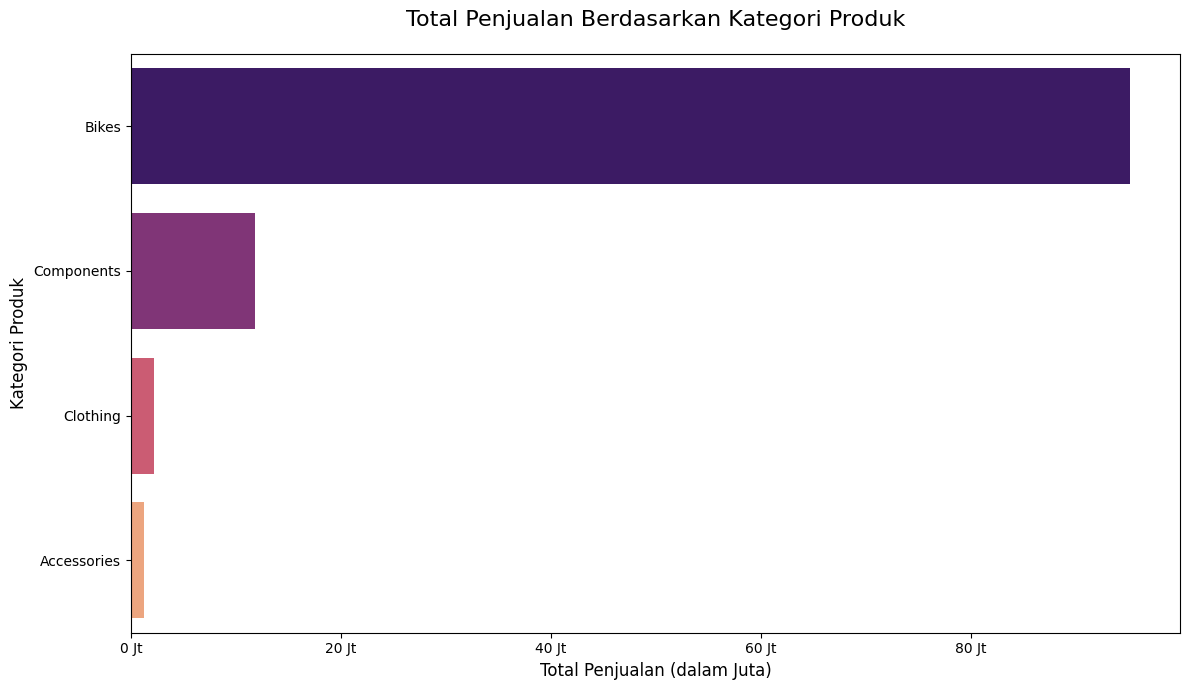

🎉 SUKSES! Grafik telah disimpan sebagai 'penjualan_per_kategori.png'.


In [53]:
print("\n\n--- Membangun Data Mart & Visualisasi untuk Penjualan per Kategori Produk ---")

# Transformasi: Tambahkan timestamp laporan
waktu_laporan_dibuat = datetime.now()
df_kategori['tgl_laporan'] = waktu_laporan_dibuat
print(f"Menambahkan timestamp laporan: {waktu_laporan_dibuat}")

# Load Hasil Analisis ke Data Mart (`adventureworks_wh`) - Mode Append
target_table_name_kategori = 'rpt_penjualan_per_kategori'
print(f"Menambahkan data ringkasan baru ke tabel '{target_table_name_kategori}' di database '{db_name_wh}'...")
df_kategori.to_sql(target_table_name_kategori, engine_wh, if_exists='append', index=False)
print(f"✅ Tabel '{target_table_name_kategori}' berhasil ditambahkan {len(df_kategori)} baris data baru.")

# Visualisasi & Simpan Gambar
print("\nMembuat visualisasi (Bar Chart) dan menyimpannya ke folder 'output'...")
plt.figure(figsize=(12, 7))
barplot = sns.barplot(x='total_penjualan', y='kategori', data=df_kategori, palette='magma')
plt.title('Total Penjualan Berdasarkan Kategori Produk', fontsize=16, pad=20)
plt.xlabel('Total Penjualan (dalam Juta)', fontsize=12)
plt.ylabel('Kategori Produk', fontsize=12)
barplot.xaxis.set_major_formatter(lambda x, pos: f'{x/1e6:.0f} Jt')
plt.tight_layout() # Untuk memastikan semua label terlihat
timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
nama_file_baru = f"{timestamp_str}_penjualan_per_kategori.png"
os.makedirs(OUTPUT_PATH, exist_ok=True)
image_path = os.path.join(OUTPUT_PATH, nama_file_baru)
plt.savefig(image_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"🎉 SUKSES! Grafik telah disimpan sebagai 'penjualan_per_kategori.png'.")

#### Hasil Analisis 2: Tren Penjualan Bulanan

Data `df_tren` akan dimuat ke `adventureworks_wh` dan divisualisasikan sebagai Line Chart



--- Membangun Data Mart & Visualisasi untuk Tren Penjualan Bulanan ---
Menambahkan timestamp laporan: 2025-06-24 13:43:52.743334
Menambahkan data ringkasan baru ke tabel 'rpt_tren_penjualan_bulanan' di database 'adventureworks_wh'...
✅ Tabel ringkasan 'rpt_tren_penjualan_bulanan' berhasil ditambahkan data baru.

Membuat visualisasi (Line Chart) dan menyimpannya ke folder 'output'...


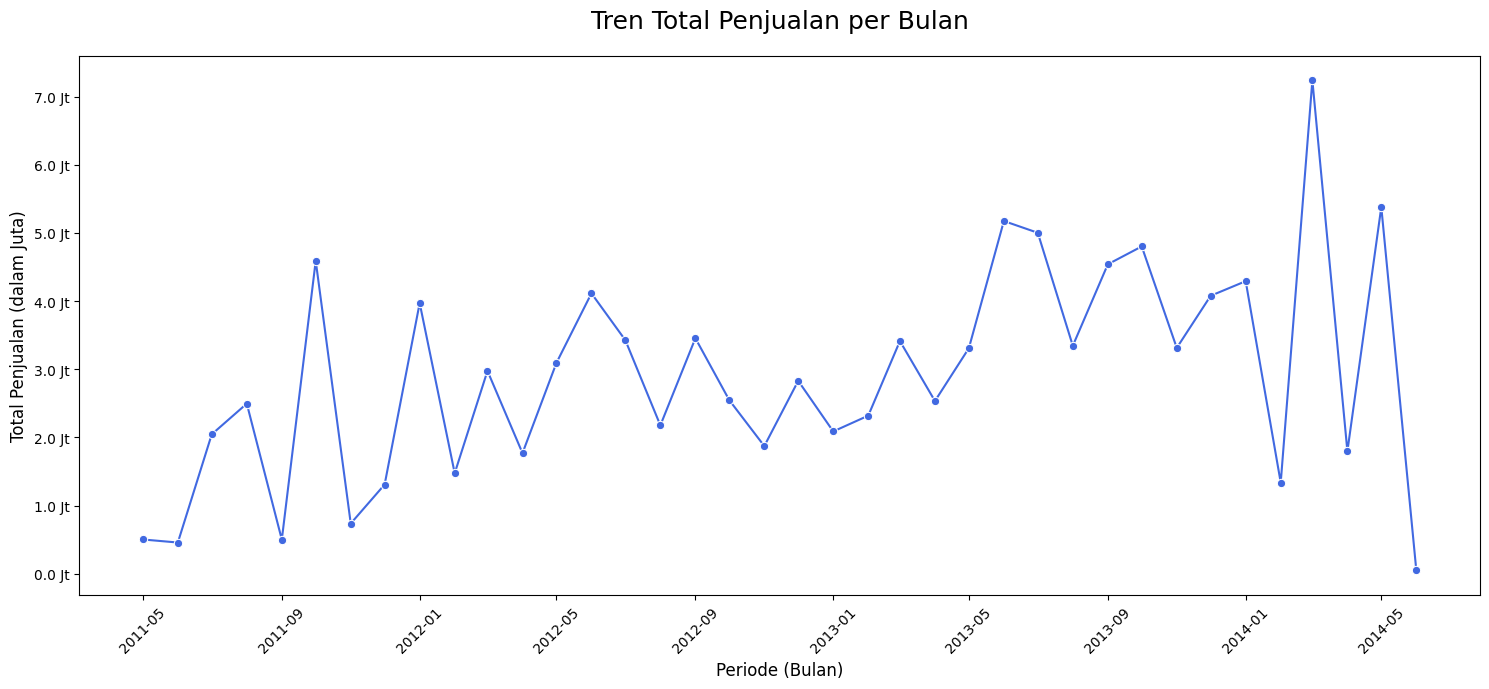

🎉 SUKSES! Grafik telah disimpan sebagai 'tren_penjualan_bulanan.png'.


In [54]:
print("\n\n--- Membangun Data Mart & Visualisasi untuk Tren Penjualan Bulanan ---")

# Transformasi: Tambahkan timestamp laporan
waktu_laporan_dibuat = datetime.now()
df_tren['tgl_laporan'] = waktu_laporan_dibuat
print(f"Menambahkan timestamp laporan: {waktu_laporan_dibuat}")

# Load Hasil Analisis ke Data Mart (`adventureworks_wh`)
target_table_name_tren = 'rpt_tren_penjualan_bulanan'
print(f"Menambahkan data ringkasan baru ke tabel '{target_table_name_tren}' di database '{db_name_wh}'...")
df_tren.to_sql(target_table_name_tren, engine_wh, if_exists='append', index=False)
print(f"✅ Tabel ringkasan '{target_table_name_tren}' berhasil ditambahkan data baru.")

# Visualisasi & Simpan Gambar
print("\nMembuat visualisasi (Line Chart) dan menyimpannya ke folder 'output'...")
plt.figure(figsize=(15, 7))
lineplot = sns.lineplot(x='periode', y='total_penjualan', data=df_tren, marker='o', color='royalblue')
plt.title('Tren Total Penjualan per Bulan', fontsize=18, pad=20)
plt.xlabel('Periode (Bulan)', fontsize=12)
plt.ylabel('Total Penjualan (dalam Juta)', fontsize=12)
plt.xticks(rotation=45)
lineplot.yaxis.set_major_formatter(lambda x, pos: f'{x/1e6:.1f} Jt')
plt.tight_layout()
timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
nama_file_baru = f"{timestamp_str}_tren_penjualan_bulanan.png"
os.makedirs(OUTPUT_PATH, exist_ok=True)
image_path = os.path.join(OUTPUT_PATH, nama_file_baru)
plt.savefig(image_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"🎉 SUKSES! Grafik telah disimpan sebagai 'tren_penjualan_bulanan.png'.")

#### Hasil Analisis 3: Top 10 Pelanggan dengan Total Belanja Terbanyak

Data `df_top_cust` akan dimuat ke `adventureworks_wh` dan divisualisasikan sebagai Horizontal Bar Chart



--- Membangun Data Mart & Visualisasi untuk Top 10 Pelanggan ---
Menambahkan timestamp laporan: 2025-06-24 13:43:52.743334
Menyimpan hasil ringkasan ke tabel 'rpt_top_10_pelanggan' di database 'adventureworks_wh'...
✅ Tabel ringkasan 'rpt_top_10_pelanggan' berhasil ditambahkan data baru.

Membuat visualisasi (Horizontal Bar Chart) dan menyimpannya ke folder 'output'...


C:\Users\Pongo\AppData\Local\Temp\ipykernel_24944\2672333238.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


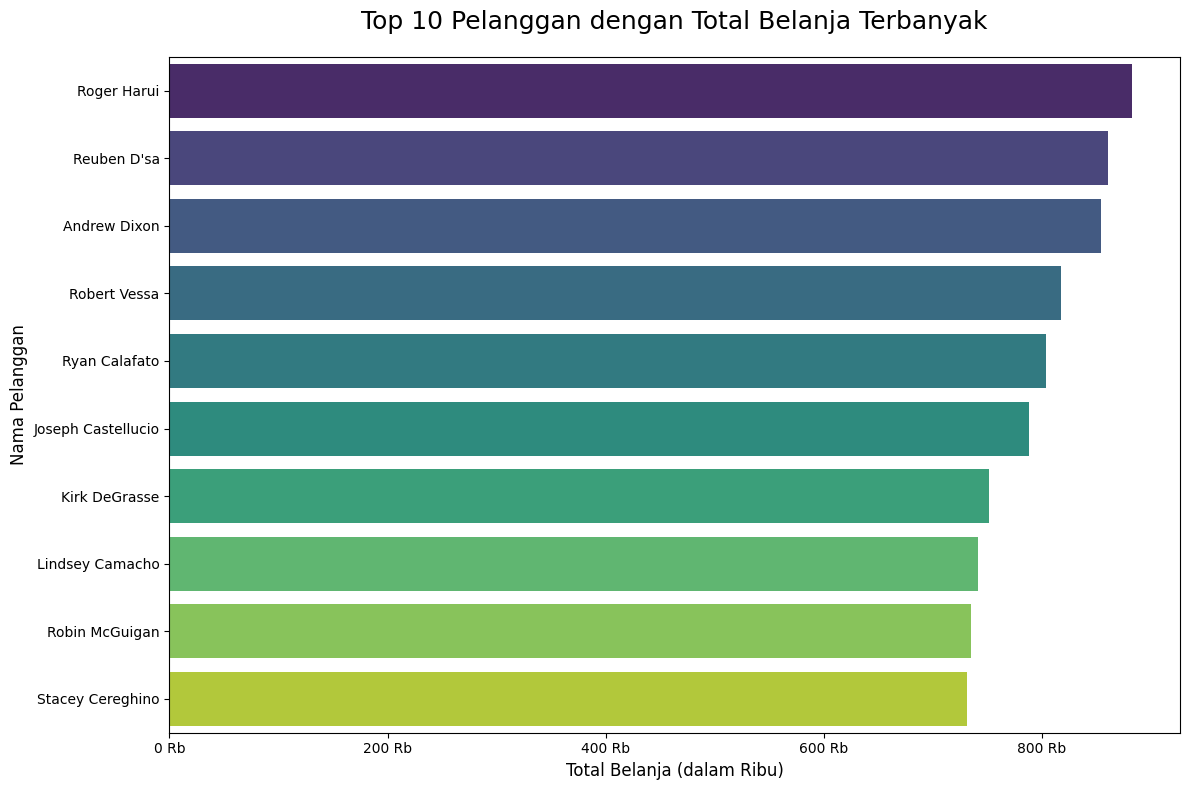

🎉 SUKSES! Grafik telah disimpan sebagai 'top_10_pelanggan.png'.


In [55]:
print("\n\n--- Membangun Data Mart & Visualisasi untuk Top 10 Pelanggan ---")

# Transformasi: Tambahkan timestamp laporan
df_top_cust['tgl_laporan'] = datetime.now()
print(f"Menambahkan timestamp laporan: {waktu_laporan_dibuat}")

# Load Hasil Analisis ke Data Mart (`adventureworks_wh`)
target_table_name_top_cust = 'rpt_top_10_pelanggan'
print(f"Menyimpan hasil ringkasan ke tabel '{target_table_name_top_cust}' di database '{db_name_wh}'...")
df_top_cust.to_sql(target_table_name_top_cust, engine_wh, if_exists='append', index=False)
print(f"✅ Tabel ringkasan '{target_table_name_top_cust}' berhasil ditambahkan data baru.")

# Visualisasi & Simpan Gambar
print("\nMembuat visualisasi (Horizontal Bar Chart) dan menyimpannya ke folder 'output'...")
plt.figure(figsize=(12, 8)) # Buat figur sedikit lebih tinggi
barplot = sns.barplot(
    x='total_belanja',
    y='nama_lengkap',
    data=df_top_cust,
    palette='viridis'
)
plt.title('Top 10 Pelanggan dengan Total Belanja Terbanyak', fontsize=18, pad=20)
plt.xlabel('Total Belanja (dalam Ribu)', fontsize=12)
plt.ylabel('Nama Pelanggan', fontsize=12)
barplot.xaxis.set_major_formatter(lambda x, pos: f'{(x/1e3):.0f} Rb')
plt.tight_layout()
timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
nama_file_baru = f"{timestamp_str}_top_10_pelanggan.png"
os.makedirs(OUTPUT_PATH, exist_ok=True)
image_path = os.path.join(OUTPUT_PATH, nama_file_baru)
plt.savefig(image_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"🎉 SUKSES! Grafik telah disimpan sebagai 'top_10_pelanggan.png'.")

#### Hasil Analisis 4: Menyimpan laporan dalam warehouse

In [56]:
if 'df_final_report' in locals():
    # Transformasi: Tambahkan timestamp laporan
    df_final_report['tgl_laporan'] = datetime.now()
    
    # Load Hasil Analisis ke Data Mart (_wh)
    target_table_name = 'rpt_sentimen_vs_penjualan'
    print(f"\nMenyimpan laporan final ke tabel '{target_table_name}'...")
    df_final_report.to_sql(target_table_name, engine_wh, if_exists='append', index=False)
    print(f"✅ Laporan final berhasil disimpan di Data Mart ('{target_table_name}')!")
else:
    print("⚠️ DataFrame 'df_final_report' tidak ditemukan. Jalankan sel analisis terlebih dahulu.")


Menyimpan laporan final ke tabel 'rpt_sentimen_vs_penjualan'...
✅ Laporan final berhasil disimpan di Data Mart ('rpt_sentimen_vs_penjualan')!
